In [69]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBRegressor, XGBClassifier  # XG Boost
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package for generating confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Package for generating classification report
from sklearn.metrics import classification_report

# Import packages to implement Stratified K-fold CV
from sklearn.model_selection import StratifiedKFold, KFold # For creating folds

# Import Package to implement GridSearch CV (Hyperparameter Tuning Method 1)
from sklearn.model_selection import GridSearchCV

# Importing package for Randomized Search CV (Hyperparameter Tuning Method 2)
from sklearn.model_selection import RandomizedSearchCV

# Time packages
import datetime as dt # Datetime
import time

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [70]:
# Import Data 
# storm_fatal_df = pd.read_csv('StormEvents_fatalities-ftp_v1.0_d2023_c20231017.csv')
# storm_fatal_df.head()

storm_location_df = pd.read_csv('StormEvents_locations-ftp_v1.0_d2023_c20231017.csv')
storm_location_df.head()

storm_details_df = pd.read_csv('StormEvents_details-ftp_v1.0_d2023_c20231017.csv')
storm_details_df.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,202302,26,2100,202302,26,2100,177004,1076081,OKLAHOMA,40,...,5.0,E,GERONIMO,34.48,-98.30,34.48,-98.30,"A powerful storm system, with highly anomalous...",Time is estimated via radar.,CSV
1,202302,26,2100,202302,26,2100,177004,1076082,OKLAHOMA,40,...,4.0,NE,WALTERS ARPT,34.40,-98.36,34.40,-98.36,"A powerful storm system, with highly anomalous...",NaN,CSV
2,202302,26,2055,202302,26,2055,177004,1076077,OKLAHOMA,40,...,4.0,ENE,NORGE,35.02,-97.93,35.02,-97.93,"A powerful storm system, with highly anomalous...",NaN,CSV
3,202302,26,2056,202302,26,2056,177004,1076079,OKLAHOMA,40,...,3.0,SSE,CHICKASHA ARPT,35.04,-97.94,35.04,-97.94,"A powerful storm system, with highly anomalous...",NaN,CSV
4,202303,26,2040,202303,26,2041,178958,1092342,GEORGIA,13,...,3.0,SE,ATLANTA,33.74,-84.37,33.74,-84.37,"A prolonged, active weather pattern persisted ...",Quarter size hail reported at Grant Park.,CSV


In [71]:
# Merge datasets
storm_df = storm_location_df.merge(storm_details_df, how="left", left_on='EVENT_ID', right_on='EVENT_ID')

#storm_df = storm_location_df.merge(storm_fatal_df, how="left", left_on='EVENT_ID', right_on='EVENT_ID')

storm_df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 41910 entries, 0 to 41909
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YEARMONTH           41910 non-null  int64  
 1   EPISODE_ID_x        41910 non-null  int64  
 2   EVENT_ID            41910 non-null  int64  
 3   LOCATION_INDEX      41910 non-null  int64  
 4   RANGE               41910 non-null  float64
 5   AZIMUTH             41910 non-null  object 
 6   LOCATION            41910 non-null  object 
 7   LATITUDE            41910 non-null  float64
 8   LONGITUDE           41910 non-null  float64
 9   LAT2                41910 non-null  int64  
 10  LON2                41910 non-null  int64  
 11  BEGIN_YEARMONTH     41910 non-null  int64  
 12  BEGIN_DAY           41910 non-null  int64  
 13  BEGIN_TIME          41910 non-null  int64  
 14  END_YEARMONTH       41910 non-null  int64  
 15  END_DAY             41910 non-null  int64  
 16  END_

In [6]:
storm_df['EVENT_TYPE'].value_counts()

Thunderstorm Wind           13538
Hail                         8265
Flood                        7975
Flash Flood                  7862
Marine Thunderstorm Wind     1667
Tornado                      1514
Heavy Rain                    446
Debris Flow                   281
Lightning                     159
Funnel Cloud                  126
Waterspout                    120
Marine High Wind               29
Marine Hail                    20
Dust Devil                      3
Name: EVENT_TYPE, dtype: int64

In [72]:
# change property damage column from string to numeric

def convert_to_numeric(value):
  value = str(value).lower()
  if 'k' in value:
      return float(value.replace('k', '')) * 1000
  elif 'm' in value:
      return float(value.replace('m', '')) * 1000000
  else:
      return float(value)

# Apply the conversion function to the column
storm_df['DAMAGE_PROPERTY'] = storm_df['DAMAGE_PROPERTY'].apply(convert_to_numeric)
storm_df['DAMAGE_CROPS'] = storm_df['DAMAGE_CROPS'].apply(convert_to_numeric)


In [73]:
# Convert date_time column to datetime object
storm_df['BEGIN_DATE_TIME'] = storm_df['BEGIN_DATE_TIME'].apply(pd.to_datetime)
storm_df['END_DATE_TIME'] = storm_df['END_DATE_TIME'].apply(pd.to_datetime)
storm_df['TIME_ELAPSED'] = storm_df['END_DATE_TIME'] - storm_df['BEGIN_DATE_TIME']

# convert time delta to minutes
storm_df['TIME_ELAPSED'] = storm_df['TIME_ELAPSED'].astype('timedelta64[m]')

# find range of tornado from lat & lon
storm_df['VERTICAL_MOVEMENT'] = abs(storm_df['BEGIN_LAT'] - storm_df['END_LAT'])
storm_df['HORIZONTAL_MOVEMENT'] = abs(storm_df['BEGIN_LON'] - storm_df['END_LON'])


In [81]:
# Making injuries into a binary classifier
storm_df['INJURIES_BINARY'] = storm_df.apply(lambda x: 'Injuries' if x['INJURIES_DIRECT'] > 0 else 'No Injuries', axis = 1)


### Tornados Prediction

In [82]:
# subset to tornados only
storm_df_t = storm_df[storm_df['EVENT_TYPE'] == 'Tornado']

storm_df_t.head()

,YEARMONTH,EPISODE_ID_x,EVENT_ID,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,...,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,TIME_ELAPSED,VERTICAL_MOVEMENT,HORIZONTAL_MOVEMENT,INJURIES_BINARY
90,202303,176783,1074118,1,2.34,ENE,NICHOLSVILLE,38.9590,-84.1280,3857540,...,-84.1280,38.9731,-84.1123,Showers and scattered thunderstorms developed ...,This short-lived tornado is believed to have t...,CSV,2.0,0.0141,0.0157,No Injuries
91,202303,176783,1074118,2,1.75,W,BETHEL,38.9731,-84.1123,3858386,...,-84.1280,38.9731,-84.1123,Showers and scattered thunderstorms developed ...,This short-lived tornado is believed to have t...,CSV,2.0,0.0141,0.0157,No Injuries
92,202303,176783,1074119,1,1.36,SW,PRICETOWN,39.1159,-83.8178,396954,...,-83.8178,39.2850,-83.6683,Showers and scattered thunderstorms developed ...,The tornado first touched down in a field sout...,CSV,14.0,0.1691,0.1495,No Injuries
93,202303,176783,1074119,2,2.30,WSW,CAREYTOWN,39.2850,-83.6683,3917100,...,-83.8178,39.2850,-83.6683,Showers and scattered thunderstorms developed ...,The tornado first touched down in a field sout...,CSV,14.0,0.1691,0.1495,No Injuries
94,202303,176783,1074120,1,1.74,N,WILLETTVILLE,39.2751,-83.7166,3916506,...,-83.7166,39.2866,-83.7088,Showers and scattered thunderstorms developed ...,This short-lived tornado is believed to have t...,CSV,2.0,0.0115,0.0078,No Injuries


<AxesSubplot: >

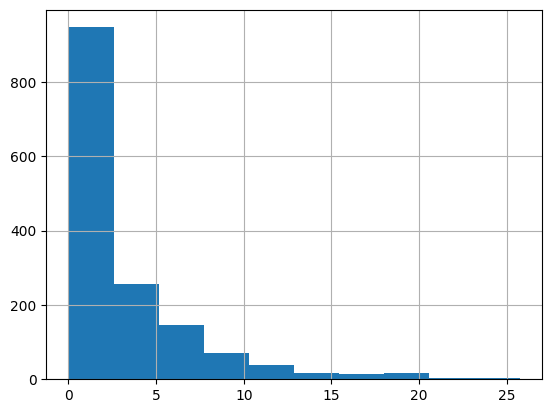

In [33]:
storm_df_t['TOR_LENGTH'].hist()

<AxesSubplot: >

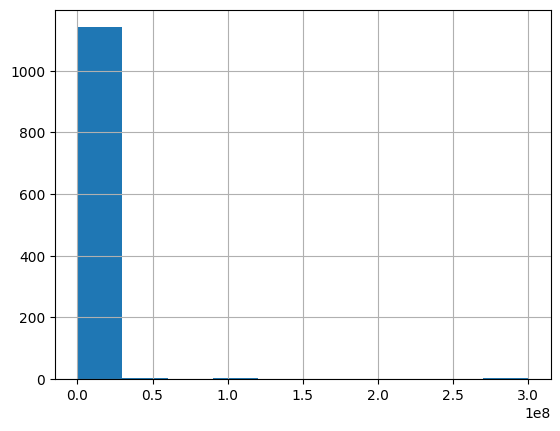

In [13]:
storm_df_t['DAMAGE_PROPERTY'].hist()

In [9]:
storm_df_t.head(10)[['EVENT_ID', 'EPISODE_ID_x', 'EVENT_TYPE','LATITUDE', 'BEGIN_LAT', 'END_LAT', 'LOCATION', 'END_LOCATION', 'BEGIN_LOCATION']]

,EVENT_ID,EPISODE_ID_x,EVENT_TYPE,LATITUDE,BEGIN_LAT,END_LAT,LOCATION,END_LOCATION,BEGIN_LOCATION
90,1074118,176783,Tornado,38.9590,38.9590,38.9731,NICHOLSVILLE,BETHEL,NICHOLSVILLE
91,1074118,176783,Tornado,38.9731,38.9590,38.9731,BETHEL,BETHEL,NICHOLSVILLE
92,1074119,176783,Tornado,39.1159,39.1159,39.2850,PRICETOWN,CAREYTOWN,PRICETOWN
93,1074119,176783,Tornado,39.2850,39.1159,39.2850,CAREYTOWN,CAREYTOWN,PRICETOWN
94,1074120,176783,Tornado,39.2751,39.2751,39.2866,WILLETTVILLE,WILLETTVILLE,WILLETTVILLE
95,1074120,176783,Tornado,39.2866,39.2751,39.2866,WILLETTVILLE,WILLETTVILLE,WILLETTVILLE
109,1074903,176783,Tornado,39.4107,39.4107,39.4211,FRANKFORT,AUSTIN,FRANKFORT
110,1074903,176783,Tornado,39.4211,39.4107,39.4211,AUSTIN,AUSTIN,FRANKFORT
198,1109633,179447,Tornado,32.2456,32.2456,32.2199,CEDARS,GRANGE HALL,CEDARS
199,1109633,179447,Tornado,32.2199,32.2456,32.2199,GRANGE HALL,GRANGE HALL,CEDARS


In [10]:
# df = storm_df[['STATE', 'CZ_TYPE', 'MAGNITUDE', 'SOURCE', 'DAMAGE_PROPERTY', 'RANGE', 'WFO', 'LATITUDE', 'LONGITUDE']]
df = storm_df_t[['STATE', 'MONTH_NAME', 'TIME_ELAPSED', 'SOURCE', 'DAMAGE_PROPERTY', 'WFO', 
                 'TOR_LENGTH', 'TOR_WIDTH', 'HORIZONTAL_MOVEMENT', 'VERTICAL_MOVEMENT']]
df.head()
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.shape

(582, 10)

In [11]:
df.head()

,STATE,MONTH_NAME,TIME_ELAPSED,SOURCE,DAMAGE_PROPERTY,WFO,TOR_LENGTH,TOR_WIDTH,HORIZONTAL_MOVEMENT,VERTICAL_MOVEMENT
90,OHIO,March,2.0,NWS Storm Survey,100000.0,ILN,1.29,200.0,0.0157,0.0141
92,OHIO,March,14.0,NWS Storm Survey,1000000.0,ILN,14.16,400.0,0.1495,0.1691
94,OHIO,March,2.0,NWS Storm Survey,100000.0,ILN,0.90,150.0,0.0078,0.0115
109,OHIO,March,1.0,NWS Storm Survey,15000.0,ILN,0.83,50.0,0.0077,0.0104
198,MISSISSIPPI,June,7.0,NWS Storm Survey,85000.0,JAN,8.54,900.0,0.1427,0.0257


In [14]:
df.corr()

,TIME_ELAPSED,DAMAGE_PROPERTY,TOR_LENGTH,TOR_WIDTH,HORIZONTAL_MOVEMENT,VERTICAL_MOVEMENT
TIME_ELAPSED,1.000000,0.066193,0.699848,0.379672,0.653104,0.566244
DAMAGE_PROPERTY,0.066193,1.000000,0.062580,0.095613,0.063249,0.041628
TOR_LENGTH,0.699848,0.062580,1.000000,0.483522,0.950471,0.797462
TOR_WIDTH,0.379672,0.095613,0.483522,1.000000,0.445355,0.404607
HORIZONTAL_MOVEMENT,0.653104,0.063249,0.950471,0.445355,1.000000,0.628322
VERTICAL_MOVEMENT,0.566244,0.041628,0.797462,0.404607,0.628322,1.000000


In [16]:
storm_df_t.columns

Index(['YEARMONTH', 'EPISODE_ID_x', 'EVENT_ID', 'LOCATION_INDEX', 'RANGE',
       'AZIMUTH', 'LOCATION', 'LATITUDE', 'LONGITUDE', 'LAT2', 'LON2',
       'BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID_y', 'STATE', 'STATE_FIPS', 'YEAR',
       'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO',
       'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME', 'INJURIES_DIRECT',
       'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE', 'MAGNITUDE',
       'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE', 'TIME_ELAPSED',
   

In [19]:
storm_df_t.head()

,YEARMONTH,EPISODE_ID_x,EVENT_ID,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,...,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,TIME_ELAPSED,VERTICAL_MOVEMENT,HORIZONTAL_MOVEMENT
90,202303,176783,1074118,1,2.34,ENE,NICHOLSVILLE,38.9590,-84.1280,3857540,...,38.9590,-84.1280,38.9731,-84.1123,Showers and scattered thunderstorms developed ...,This short-lived tornado is believed to have t...,CSV,2.0,0.0141,0.0157
91,202303,176783,1074118,2,1.75,W,BETHEL,38.9731,-84.1123,3858386,...,38.9590,-84.1280,38.9731,-84.1123,Showers and scattered thunderstorms developed ...,This short-lived tornado is believed to have t...,CSV,2.0,0.0141,0.0157
92,202303,176783,1074119,1,1.36,SW,PRICETOWN,39.1159,-83.8178,396954,...,39.1159,-83.8178,39.2850,-83.6683,Showers and scattered thunderstorms developed ...,The tornado first touched down in a field sout...,CSV,14.0,0.1691,0.1495
93,202303,176783,1074119,2,2.30,WSW,CAREYTOWN,39.2850,-83.6683,3917100,...,39.1159,-83.8178,39.2850,-83.6683,Showers and scattered thunderstorms developed ...,The tornado first touched down in a field sout...,CSV,14.0,0.1691,0.1495
94,202303,176783,1074120,1,1.74,N,WILLETTVILLE,39.2751,-83.7166,3916506,...,39.2751,-83.7166,39.2866,-83.7088,Showers and scattered thunderstorms developed ...,This short-lived tornado is believed to have t...,CSV,2.0,0.0115,0.0078


In [31]:
storm_df_t[['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'STATE', 'STATE_FIPS', 'YEAR',
       'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO',
       'INJURIES_DIRECT','INJURIES_INDIRECT', 
       'DEATHS_DIRECT', 'DEATHS_INDIRECT',
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
       'SOURCE', 'MAGNITUDE', 
       'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 
       'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'TIME_ELAPSED',
       'VERTICAL_MOVEMENT', 'HORIZONTAL_MOVEMENT']].drop_duplicates().corr()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,STATE_FIPS,YEAR,CZ_FIPS,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,...,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_CZ_FIPS,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,TIME_ELAPSED,VERTICAL_MOVEMENT,HORIZONTAL_MOVEMENT
BEGIN_YEARMONTH,1.000000,0.015833,0.125650,0.043841,NaN,-0.041130,0.006509,NaN,0.001977,-0.029931,...,-0.111233,-0.080555,-0.053519,0.353064,-0.214276,0.350604,-0.214586,0.043653,-0.185186,-0.060438
BEGIN_DAY,0.015833,1.000000,0.274194,-0.008946,NaN,0.000182,0.027606,NaN,0.007660,0.058763,...,0.022657,0.025453,0.016893,0.089306,-0.064405,0.089246,-0.064022,0.028352,0.007029,0.041871
BEGIN_TIME,0.125650,0.274194,1.000000,0.135678,NaN,0.061223,-0.007143,NaN,-0.035711,-0.009220,...,-0.020388,-0.036848,-0.110371,0.178652,-0.105805,0.178696,-0.106008,0.030296,0.030624,-0.045472
STATE_FIPS,0.043841,-0.008946,0.135678,1.000000,NaN,0.172138,0.032432,NaN,0.028087,-0.051024,...,0.047946,-0.033601,-0.041146,0.122846,-0.104646,0.123004,-0.104367,0.091018,0.083381,0.036357
YEAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CZ_FIPS,-0.041130,0.000182,0.061223,0.172138,NaN,1.000000,0.114797,NaN,0.081492,0.008928,...,0.117775,0.014052,0.104829,-0.200969,-0.069386,-0.201178,-0.068664,0.064898,0.114244,0.087271
INJURIES_DIRECT,0.006509,0.027606,-0.007143,0.032432,NaN,0.114797,1.000000,NaN,0.439772,0.455867,...,0.179563,0.204607,-0.041562,-0.043171,-0.023255,-0.042858,-0.021904,0.112940,0.152183,0.180954
INJURIES_INDIRECT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEATHS_DIRECT,0.001977,0.007660,-0.035711,0.028087,NaN,0.081492,0.439772,NaN,1.000000,-0.003314,...,0.196826,0.129745,-0.105516,-0.027236,-0.004269,-0.027038,-0.003078,0.107531,0.214436,0.161671
DEATHS_INDIRECT,-0.029931,0.058763,-0.009220,-0.051024,NaN,0.008928,0.455867,NaN,-0.003314,1.000000,...,0.218341,0.100991,-0.017384,-0.023155,0.000460,-0.021990,0.002046,0.104759,0.163309,0.220760


In [63]:
storm_df_t[['BEGIN_DAY', 'BEGIN_TIME', 'STATE', #'YEAR', # all 2023
       'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_NAME', 'WFO',
       'INJURIES_DIRECT',  # 'INJURIES_INDIRECT',   # note: there are no indirect injuries
       'DEATHS_DIRECT', #'DEATHS_INDIRECT',
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
       'SOURCE',
       'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'TIME_ELAPSED',
       'VERTICAL_MOVEMENT', 'HORIZONTAL_MOVEMENT']].drop_duplicates().dropna().corr()[['INJURIES_DIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS']]

,INJURIES_DIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS
BEGIN_DAY,-0.014745,-0.014089,0.054595
BEGIN_TIME,-0.084198,-0.052888,-0.016855
INJURIES_DIRECT,1.000000,0.623738,-0.009497
DEATHS_DIRECT,0.275485,0.002354,-0.003475
DAMAGE_PROPERTY,0.623738,1.000000,-0.003869
DAMAGE_CROPS,-0.009497,-0.003869,1.000000
TOR_LENGTH,0.206188,0.056271,-0.019952
TOR_WIDTH,0.187812,0.092384,-0.006329
BEGIN_LAT,-0.108273,-0.028107,0.066709
BEGIN_LON,0.074655,0.079286,0.036779


In [39]:
storm_df_t[['BEGIN_DAY', 'BEGIN_TIME', 'STATE', #'YEAR', # all 2023
       'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_NAME', 'WFO',
       'INJURIES_DIRECT',  # 'INJURIES_INDIRECT',   # note: there are no indirect injuries
       'DEATHS_DIRECT', #'DEATHS_INDIRECT',
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
       'SOURCE',
       'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'TIME_ELAPSED',
       'VERTICAL_MOVEMENT', 'HORIZONTAL_MOVEMENT']].drop_duplicates().dropna()['DEATHS_DIRECT'].value_counts()

0    558
1      2
5      1
Name: DEATHS_DIRECT, dtype: int64

In [40]:
df_injuries = storm_df_t[['BEGIN_DAY', 'BEGIN_TIME', 'STATE', 
       'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_NAME', 'WFO',
       'INJURIES_DIRECT', 
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
       'SOURCE',
       'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'TIME_ELAPSED',
       'VERTICAL_MOVEMENT', 'HORIZONTAL_MOVEMENT']]

### Initial Basic XGBoost Model

In [80]:
# set target variable
X = df.drop(columns = ['DAMAGE_PROPERTY'])
y = df['DAMAGE_PROPERTY']

# encode categorical variables
cat_var = ['STATE', 'MONTH_NAME', 'SOURCE', 'WFO']
X_encoded = pd.get_dummies(X, columns = cat_var)

# split train/test dataset
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.3, random_state = 1)


In [65]:
from sklearn.ensemble import RandomForestRegressor

In [66]:
# Defining prediction model
clf = RandomForestRegressor(random_state = 0)

# Fitting model on training data
clf.fit(train_X, train_y)

RandomForestRegressor(random_state=0)

In [67]:
from sklearn.metrics import r2_score
# Predictions on test set
y_pred = clf.predict(test_X)
# R-2 score using r2_score(y_true, y_pred)
r2_score(test_y, y_pred)

-3632.136963839568

## K-fold CV w/ Tuning for XGBoost

In [83]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.3, random_state = 42)

# Creating folds
folds = KFold(n_splits = 3, shuffle = True, random_state = 100)

In [70]:
# Define the model
XGregressor = XGBRegressor(random_state = 42)

In [83]:
random_grid = {
    'max_depth': list(range(2,30,2)),
    'min_child_weight':list(range(1,60, 2)),
    'n_estimators': list(range(2, 30, 2))
}

print(random_grid)

xg_model_cv = RandomizedSearchCV(estimator = XGregressor, 
                                param_distributions = random_grid, 
                                n_iter = 40,
                                scoring='r2',
                                n_jobs=4,
                                cv=folds, 
                                random_state = 42)

{'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'min_child_weight': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59], 'n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]}


In [84]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Training time: 7.40926194190979s
Initial score:  -37.157850637327556
Initial parameters:  {'n_estimators': 2, 'min_child_weight': 51, 'max_depth': 26}


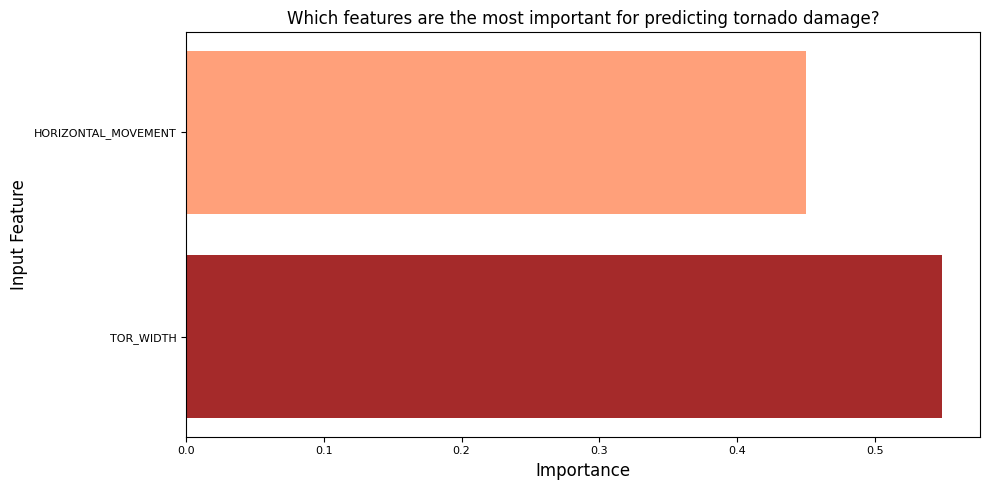

In [85]:
# XG Boost Feature Importance
# Storing importance values from the trained model
importance = xg_model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])
feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Selecting features with non-zero importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.001]

# Bar plot
fig4 = plt.figure(figsize=(10, 5))
plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color = ['brown', 'lightsalmon'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting tornado damage?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();

# Injuries

In [51]:
df_injuries = storm_df_t[['BEGIN_DAY', 'BEGIN_TIME', 'STATE', 
       'MONTH_NAME', 'CZ_TYPE', 'CZ_NAME', 'WFO',
       'INJURIES_DIRECT', 
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
       'SOURCE',
       'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'TIME_ELAPSED',
       'VERTICAL_MOVEMENT', 'HORIZONTAL_MOVEMENT']].drop_duplicates().dropna()

In [64]:
df_injuries['INJURIES_DIRECT'].value_counts()

0     535
2       8
1       7
3       3
5       2
4       2
7       1
11      1
16      1
6       1
Name: INJURIES_DIRECT, dtype: int64

In [53]:
df_injuries['TOR_F_SCALE'].value_counts()

EF0    243
EF1    166
EFU    109
EF2     38
EF3      5
Name: TOR_F_SCALE, dtype: int64

In [66]:
df_injuries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561 entries, 90 to 41837
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BEGIN_DAY            561 non-null    int64  
 1   BEGIN_TIME           561 non-null    int64  
 2   STATE                561 non-null    object 
 3   MONTH_NAME           561 non-null    object 
 4   CZ_TYPE              561 non-null    object 
 5   CZ_NAME              561 non-null    object 
 6   WFO                  561 non-null    object 
 7   INJURIES_DIRECT      561 non-null    int64  
 8   DAMAGE_PROPERTY      561 non-null    float64
 9   DAMAGE_CROPS         561 non-null    float64
 10  SOURCE               561 non-null    object 
 11  TOR_F_SCALE          561 non-null    object 
 12  TOR_LENGTH           561 non-null    float64
 13  TOR_WIDTH            561 non-null    float64
 14  BEGIN_LAT            561 non-null    float64
 15  BEGIN_LON            561 non-null    

In [55]:
# set target variable
X = df_injuries.drop(columns = ['INJURIES_DIRECT'])
y = df_injuries['INJURIES_DIRECT']

# encode categorical variables
cat_var = ['STATE', 'MONTH_NAME', 'CZ_TYPE', 'CZ_NAME', 'WFO','SOURCE', 'TOR_F_SCALE']
X_encoded = pd.get_dummies(X, columns = cat_var)

# split train/test dataset
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.3, random_state = 1)

# Creating folds
folds = KFold(n_splits = 3, shuffle = True, random_state = 100)


In [56]:
# Defining prediction model
clf = RandomForestRegressor(random_state = 0)

# Fitting model on training data
clf.fit(train_X, train_y)

RandomForestRegressor(random_state=0)

In [57]:
from sklearn.metrics import r2_score
# Predictions on test set
y_pred = clf.predict(test_X)
# R-2 score using r2_score(y_true, y_pred)
r2_score(test_y, y_pred)

-0.0027481981302777125

In [60]:
# Define the model
XGregressor = XGBRegressor(random_state = 42)

In [61]:
random_grid = {
    'max_depth': list(range(2,30,2)),
    'min_child_weight':list(range(1,60, 2)),
    'n_estimators': list(range(2, 30, 2))
}

print(random_grid)

xg_model_cv = RandomizedSearchCV(estimator = XGregressor, 
                                param_distributions = random_grid, 
                                n_iter = 40,
                                scoring='r2',
                                n_jobs=4,
                                cv=folds, 
                                random_state = 42)

{'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'min_child_weight': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59], 'n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]}


In [62]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Training time: 8.503791809082031s
Initial score:  0.20336650216050264
Initial parameters:  {'n_estimators': 24, 'min_child_weight': 21, 'max_depth': 26}


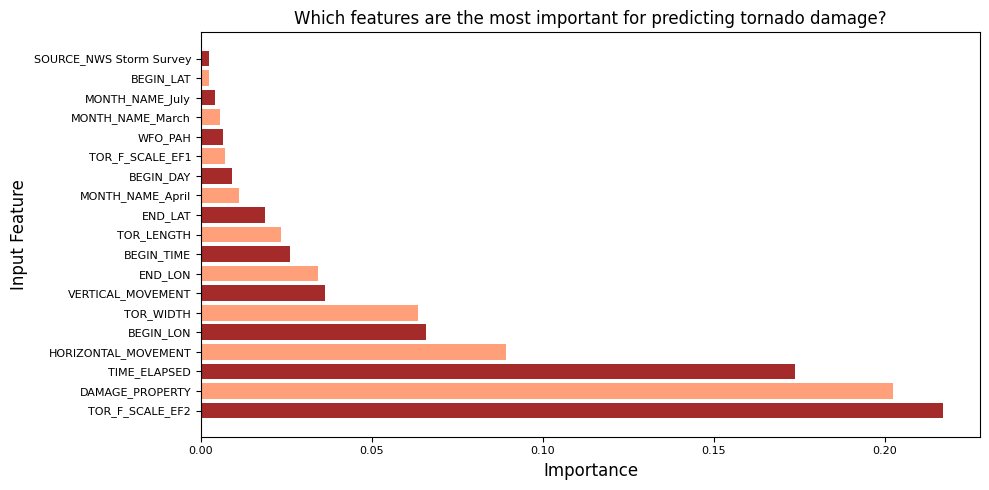

In [67]:
# XG Boost Feature Importance
# Storing importance values from the trained model
importance = xg_model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])
feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Selecting features with non-zero importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.001]

# Bar plot
fig4 = plt.figure(figsize=(10, 5))
plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color = ['brown', 'lightsalmon'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting tornado damage?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();

## Injuries Classification

In [90]:
# Making injuries into a binary classifier
storm_df_t['INJURIES_BINARY'] = storm_df_t.apply(lambda x: 1 if x['INJURIES_DIRECT'] > 0 else 0, axis = 1)


In [117]:
def f(row):
    if row['INJURIES_DIRECT'] > 5:
        val = 2
    elif row['INJURIES_DIRECT'] > 0:
        val = 1
    else:
        val = 0
    return val

In [118]:
# Making injuries into a classifier
storm_df_t['INJURIES_CLASS'] = storm_df_t.apply(f, axis = 1)


In [119]:
df_injuries = storm_df_t[['BEGIN_DAY', 'BEGIN_TIME', 'STATE', 
       'MONTH_NAME', 'CZ_TYPE', 'CZ_NAME', 'WFO',
       'INJURIES_CLASS', 
  #     'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 
       'SOURCE',
   #    'TOR_F_SCALE', 
       'TOR_LENGTH', 'TOR_WIDTH', 
       'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 'TIME_ELAPSED',
       'VERTICAL_MOVEMENT', 'HORIZONTAL_MOVEMENT']].drop_duplicates().dropna()

In [120]:
# set target variable
X = df_injuries.drop(columns = ['INJURIES_CLASS'])
y = df_injuries['INJURIES_CLASS']

# encode categorical variables
cat_var = ['STATE', 'MONTH_NAME', 'CZ_TYPE', 'CZ_NAME', 'WFO','SOURCE']#, 'TOR_F_SCALE']
X_encoded = pd.get_dummies(X, columns = cat_var)

# split train/test dataset
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.3, random_state = 1)

# Creating folds
folds = KFold(n_splits = 3, shuffle = True, random_state = 100)


In [121]:
# model algorithm
XBClassifier = XGBClassifier(random_state = 42)

In [122]:
random_grid = {
    'max_depth': list(range(2,30,2)),
    'min_child_weight':list(range(1,60, 2)),
    'n_estimators': list(range(2, 30, 2))
}

print(random_grid)

xg_model_cv = RandomizedSearchCV(estimator = XBClassifier, 
                                param_distributions = random_grid, 
                                n_iter = 40,
                                scoring='f1_weighted',
                                n_jobs=4,
                                cv=folds, 
                                random_state = 42)

{'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'min_child_weight': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59], 'n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]}


In [123]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Training time: 7.410918712615967s
Initial score:  0.9163178684500272
Initial parameters:  {'n_estimators': 22, 'min_child_weight': 5, 'max_depth': 14}


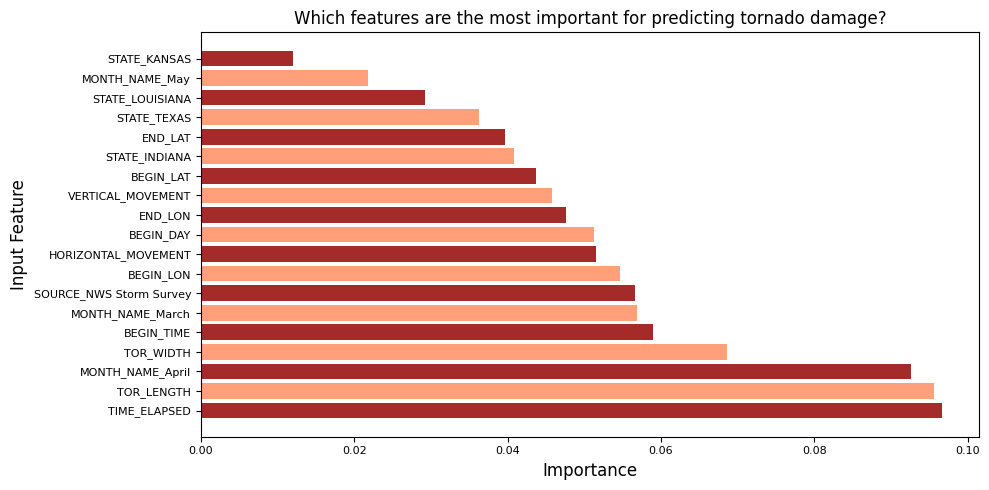

In [124]:
# XG Boost Feature Importance
# Storing importance values from the trained model
importance = xg_model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])
feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Selecting features with non-zero importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.001]

# Bar plot
fig4 = plt.figure(figsize=(10, 5))
plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color = ['brown', 'lightsalmon'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting tornado damage?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();